# Welcome to the local activation analysis tutorial!

Medusa's local activation module implements several parameters focused on analyzing the signal of each sensor individually. That is, the parameters in this category return a single value for sensor and epoch. The parameters here can be divided in two sub-categories: spectral and non-linear. The **spectral parameters** measure different properties of the signal's power spectral density. On the other hand, the **non-linear parameters** assess the time courses of the signals, evaluating its non-linear properties such as the complexity, irregularity, or variability.

This notebook will cover the main functions of the module through illustrative examples that will allow you to get started in biosignal analysis with Medusa.

In this notebook you will learn:
    - Download an open EEG dataset and explore the files
    - Pre-process the EEG signal with Medusa filters
    - Know the different spectral parameters
    - Know the different non-linear parameters
    - Get some plots with Medusa's plot functions

Do not forget to check the documentation if you do not understand something!

## Imports

Import the modules that will be used in this notebook.

In [1]:
# General imports
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
from tabulate import tabulate
import glob

# Medusa imports
from medusa import components
from medusa.meeg import meeg
from medusa import transforms
from medusa.spatial_filtering import LaplacianFilter
from medusa.frequency_filtering import FIRFilter
from medusa.local_activation import spectral_parameteres,nonlinear_parameters
from medusa.transforms import power_spectral_density
from medusa.epoching import get_epochs
from medusa.plots.head_plots import plot_topography, plot_head

## Download the dataset

As strong supporters of open science, we have released and adapted some
valuable datasets that can be very useful for researchers and practitioners.
These datasets can be downloaded manually from www.medusabci.com/datasets/ or
using a simple API. In this case, we will use the API. Run the following cell
to download the GIB-UVa ERP dataset [1].

Each file is an instance of medusa.data_structures.Recording. This class
contains the information of the performed experiment and the recorded biosignals
In this case, the recordings contain an instance of
medusa.components.ERPSpellerData, which is the default class for this
experiment. Additionally, all recordings contain a medusa.meeg.EEG instance.

In [2]:
#This functionality is not yet implemented, so the code needed to generate a synthetic signal is included.

# dataset_folder = os.getcwd()
print('WARNING: This functionality is not yet implemented, so a synthetic signal is used instead!')
# Signal parameters
l_cha = ['F7','F3','FZ','F4','F8','FCz','C3','CZ','C4','CPz','P3','PZ','P4',
         'PO7','POZ','PO8'] # Channel labels
fs = 256 # Sampling frequency
T = 120 # Signal duration
times = np.arange(0,T,1/fs) # Times vector
freqs = [4, 10, 13] # Fundamental signal frequencies
A_freqs = [1.2, 0.8, 0.5] # Frequencies amplitudes
A_noise = 1 # Noise amplitude
sigma = 0.75 # Gaussian noise variance
ps = np.linspace(0,-np.pi/2,len(l_cha)) # Phase differences between channels

# Define signal
signal = np.empty((len(times),len(l_cha)))
for c in range(len(l_cha)):
    signal[:,c] = A_freqs[0] * np.sin(2 * np.pi * freqs[0] * times - ps[c]) + A_freqs[1] * np.sin(2 * np.pi * freqs[1] * times - ps[c]) + A_freqs[2] * np.sin(2 * np.pi * freqs[2] * times - ps[c]) + A_noise * np.random.normal(
            0, sigma, size=times.shape)

# Create a channel set
ch_set = meeg.meeg.EEGChannelSet()
ch_set.set_standard_montage(l_cha=l_cha,montage='10-05')

print("If you have run this cell, you must not run the following cell (Explore de EEG file)")

# Print some info of the extracted features
data_exploration = [
    ['Sampling rate (Hz)', fs],
    ['Channel labels', ch_set.l_cha],
    ['Signal duration (s)', T]]

print('\nData exploration: \n')
print(tabulate(data_exploration))

If you have run this cell, you must not run the following cell (Explore de EEG file)

Data exploration: 

-------------------  -----------------------------------------------------------------------------------------------------
Sampling rate (Hz)   256
Channel labels       ['F7', 'F3', 'FZ', 'F4', 'F8', 'FCZ', 'C3', 'CZ', 'C4', 'CPZ', 'P3', 'PZ', 'P4', 'PO7', 'POZ', 'PO8']
Signal duration (s)  120
-------------------  -----------------------------------------------------------------------------------------------------


## Explore the EEG file

Once we have downloaded the EEG recording dataset, we will import the files and extract
interesting information such as the channels used, the sampling frequency, or a copy of the signal.

In [3]:
# Load one recording from the dataset
# folder = 'data'
# file_pattern = '*.rec.bson'
# files = glob.glob('%s/%s' % (folder, file_pattern))
# recording = components.Recording.load(files[0])
#
# # Get the EEG signal and time-stamps vector from recording
# signal = recording.eeg.signal.copy()
# times = recording.eeg.times.copy()
#
# # Get the EEG Channel set and sampling rate
# ch_set = recording.eeg.channel_set
# fs = recording.eeg.fs
#
# # Print some info of the extracted features
# data_exploration = [
#     ['Sampling rate (Hz)', fs],
#     ['Channel labels', ch_set.l_cha],
#     ['Signal duration (s)', len(times)/fs]]
#
# print('\nData exploration: \n')
# print(tabulate(data_exploration))

## Signal Pre-processing

Now it is time to prepare our signal to the incoming analyses. To do so, we have to apply a proper
spacial and spectral pre-processing!

Let's suppose that we want to focus our analyses on Fz, C3 and C4 channels. Firstly, we want to
emphasize the activity we are interested in. Therefore, we will apply a surface Laplacian spatial
filter to eliminate the highly correlated activity of the surrounding channels. Then, a band-pass
filter between 0.5 Hz and 30 Hz is then applied to reject the influence of the DC line noise components.
We will use a finite impulse response (FIR) filter with a Hamming window. Finally, the signal will be
divided into epochs of 5 seconds duration.


 The Laplacian filter for FZ are: 
FCz 
F4 
F3 

 The Laplacian filter for C3 are: 
CZ 
F3 
P3 

 The Laplacian filter for C4 are: 
CZ 
F4 
P4 


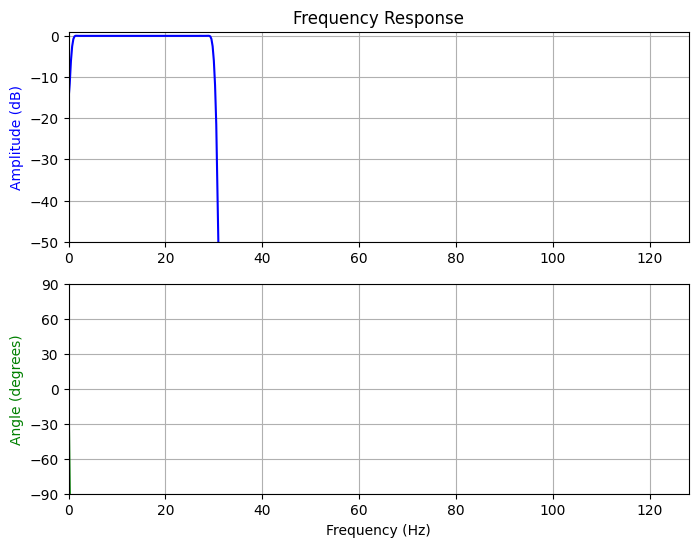

The pre-processing stage is finished!
(24, 1280, 3)


In [4]:
# Create an instance of Laplacian filter and fit it
l_cha_to_filter=['FZ','C3','C4']
lp_filter = LaplacianFilter(channel_set=ch_set,mode='auto')
lp_filter.fit_lp(l_cha_to_filter=l_cha_to_filter)
# Mode 'auto' automatically calculates the best small laplacian filter. Let's print
# the channels used to calculate the filter for each studied channel

for i, filter in enumerate(lp_filter.lp_filter):
    print('\n The Laplacian filter for ' + l_cha_to_filter[i] + ' are: ')
    for ch in filter:
        print(f'{l_cha[ch]} ')


# Apply surface Laplacian filter
signal_lpf = lp_filter.apply_lp(signal.copy())

# Create an instance of FIR filter and fit it
order = 500 # Order of the filter
cutoff = [0.5,30]
btype = 'bandpass' # Type of the filter
window = 'hamming'
filt_method = 'filtfilt' # Filtering method
axis = 0
fir_filter = FIRFilter(order=order,cutoff=cutoff,btype=btype,window=window,
                       filt_method=filt_method,axis=axis)
fir_filter.fit(fs=fs)
# Display the FIR filter
fir_filter.display()

# Apply the FIR filter
signal_f = fir_filter.transform(signal=signal_lpf)

# Dived into 5 s epochs
signal_epochs = get_epochs(signal=signal_f,epochs_length=int(5*fs),stride=None,norm=None)

print("The pre-processing stage is finished!")
print(signal_epochs.shape)

## Spectral Analysis

### PSD calculation
Once we have correctly  pre-processed our signal, we can perform the spectral analysis. These analyses star
with the calculation of the power spectral density (PSD) using the Welch periodograms method [2]. We will
calculate each PSD separately for each study channel (i.e, Fz, C3 and C4). We will then plot each PSD.

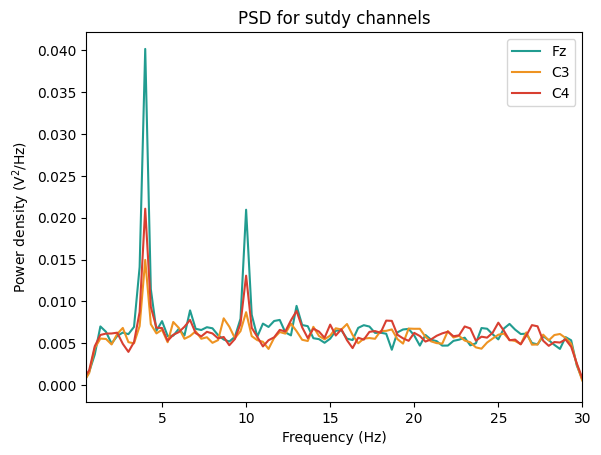

In [5]:
# First, define welch method parameters
window_length = 3 # Lenght in seconds of the window used to compute the FFT
segment_pct = (window_length/5)*100 # Percentage of the original signal used  to calculate the FFT
overlap_pct = 50 # Percentage of overlap for the Welch method
window = 'hamming' # Desired window to use. See scipy.signal.welch docs for more details

# Let us obtain the estimated PSD of each study channel.
freq_array, psd = power_spectral_density(signal=signal_epochs,fs=fs,segment_pct=segment_pct,
                                         overlap_pct=overlap_pct,window=window)
# Plot the PSD for each channel
figure, axes = plt.subplots()
axes.plot(freq_array,psd.mean(axis=0)[:,0],color='#219C90') # PSD of Fz (all epochs are averaged)
axes.plot(freq_array,psd.mean(axis=0)[:,1],color='#EE9322') # PSD of C3 (all epochs are averaged)
axes.plot(freq_array,psd.mean(axis=0)[:,2],color='#D83F31') # PSD of C4 (all epochs are averaged)
axes.set_xlim(0.5,30) # Set the x-range of frequencies  to plot
axes.set_title('PSD for sutdy channels') # Set the plot title
axes.set_xlabel('Frequency (Hz)') # Set the x-label
axes.set_ylabel('Power density $\mathregular{(V^2/Hz)}$') # Set the y-label
axes.legend(['Fz','C3','C4']) # Set the legend

### Spectral parameters calculation
Now we will calculate the following spectral-based parameters:
- Absolute band-power (for the canonical frequency bands used in EEG research)
- Median frequency of alpha band

These metrics allow a first basic analysis of the EEG signal. They can be useful in practical
cases such as in the study of the effects of Alzheimer's disease on the EEG, where a clear
increase in the power of the slow frequency bands (i.e. delta and theta) is seen, to the detriment
of the fast ones [3]. This can also be characterized as a slowing of the alpha peak [3].

------------------------------------------------------

 The median frequency of the alpha band in Fz is 9.902777777777777 Hz

 The median frequency of the alpha band in C3 is 9.819444444444445 Hz

 The median frequency of the alpha band in C4 is 10.055555555555555 Hz

------------------------------------------------------


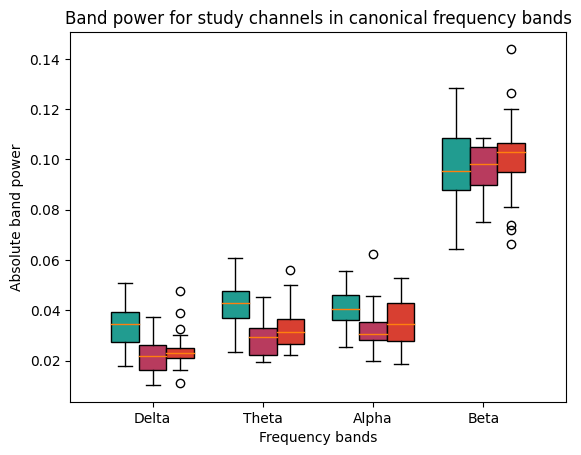

In [6]:
# Let us define the canonical frequency bands
freq_bands = [[1,4],[4,8],[8,13],[13,30]]

# Create an empty vector to save the band-power
powers = np.empty((3,psd.shape[0],4))

# Calculate the powers
for i_b, bands in enumerate(freq_bands):
    pow_values = spectral_parameteres.absolute_band_power(psd=psd,fs=fs,target_band=bands)
    for ch in range(3):
        powers[ch,:,i_b] = pow_values[:,ch]

# Plot the powers
figure, axes = plt.subplots()
x = np.arange(4)
w = 0.25
b_fz = axes.boxplot(positions=x-w,x =powers[0,:,:],widths=w,patch_artist=True)
b_c3 = axes.boxplot(positions=x,x =powers[1,:,:],widths=w,patch_artist=True)
b_c4 = axes.boxplot(positions=x+w,x =powers[2,:,:],widths=w,patch_artist=True)
#
for patch in b_fz['boxes']:
    patch.set_facecolor('#219C90')
for patch in b_c3['boxes']:
    patch.set_facecolor('#B83B5E')
for patch in b_c4['boxes']:
    patch.set_facecolor('#D83F31')
axes.set_xticks(np.arange(4),['Delta','Theta','Alpha','Beta'])
axes.set_xlabel('Frequency bands')
axes.set_ylabel('Absolute band power')
axes.set_title('Band power for study channels in canonical frequency bands')

# Calculate the median frequency of alpha band
mf_alpha = spectral_parameteres.median_frequency(psd=psd,fs=fs,target_band=[8,13])
print("------------------------------------------------------")
print(f"\n The median frequency of the alpha band in Fz is {mf_alpha[:,0].mean()} Hz")
print(f"\n The median frequency of the alpha band in C3 is {mf_alpha[:,1].mean()} Hz")
print(f"\n The median frequency of the alpha band in C4 is {mf_alpha[:,2].mean()} Hz")
print("\n------------------------------------------------------")



## Non-linear Analysis

In contrast to spectral analysis measures, nonlinear analysis measures seek to describe
the complex structure of the systems, which can be characterized by the nonlinear relationships
of the associated signals. In this sense, this type of analysis seeks to describe signal
characteristics such as its irregularity, complexity, or long-range dependencies.

Medusa-Kernel provides some of the most typically employed nonlinear irregularity and complexity
analysis methods. In this section we will explore the use of sample entropy (SampEn) [4], which will
give us an idea of the irregularity of the signal. Next, we will employ multiscale entropy (MSE) [4],
which calculates signal irregularity using SampEn at different time scales, thus providing insight into
signal complexity. Finally, Lempel-Ziv complexity (LZC) [5], which evaluates the randomness of finite
sequences based on the number of distinct patterns in a signal, will be used.

### Sample Entropy

Non-linear analysis measurements study temporal relationships between signal samples, so to better capture
these properties, it is necessary to use longer time windows than in spectral analysis. For this reason, we
will perform a new windowing prior to the calculation of the metrics.

It is important to note that in order to optimize the calculation of these multi-channel measurements, MEDUSA
implements these analyses using concurrent programming. For this reason, the use of too long signals can lead
to memory allocation errors.

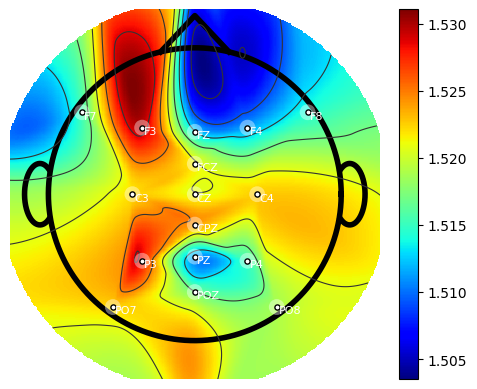

In [7]:
# We define new longer periods
signal_long_epochs = get_epochs(signal=signal,epochs_length=int(20*fs),stride=None,norm=None)

# SampEn parameters
m = 1 # Sequence length
r = 0.3 # Tolerance
dist_type = 'chebyshev' # Distance metric

# Obtain SampEn
signal_sampen = nonlinear_parameters.sample_entropy(signal=signal_long_epochs,
                                                    m=m,r=r,dist_type=dist_type)
# Plot the SampEn values averaged across epochs
fig,axes = plt.subplots()
norm = colors.Normalize(vmin=signal_sampen.mean(axis=0).min(),
                        vmax=signal_sampen.mean(axis=0).max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
plot_head(axes=axes,channel_set=ch_set,plot_channel_labels=True)
plot_topography(values=signal_sampen.mean(axis=0),axes=axes,channel_set=ch_set,cmap='jet')
fig.colorbar(mapper,ax=axes,fraction=0.046,pad=0.04)

### Multiscale Entropy

Next we will use the MSE calculation function, which performs the SampEn calculation on different versions of
the signal, to which a coarse-grained approximation will be applied.  To understand this process, see [5] and
the implementation in our documentation.

C:\Users\Diego\AppData\Local\Temp\ipykernel_8048\3485498029.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(np.arange(max_scale))


Text(0.5, 0, 'Time scales')

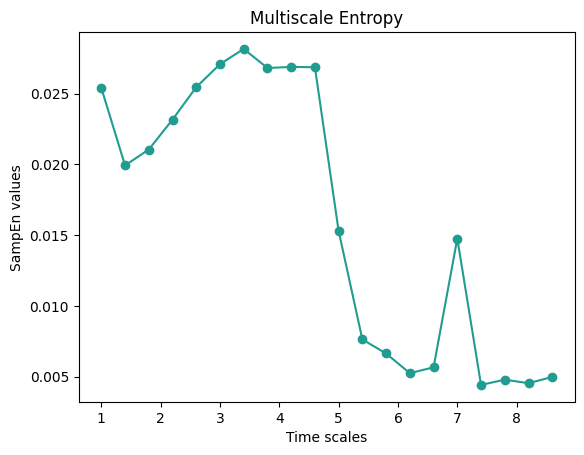

In [8]:
# Let us define the parameters of MSE algorithm
max_scale = 20 # Maximum scale value
m = 1 # Sequence length
r = 0.3 # Tolarence

# Obtain mse for just one channel (e.g., Fz)
mse = nonlinear_parameters.multiscale_entropy(signal=signal_long_epochs[:,:,2,None],
                                              max_scale=max_scale,m=m,r=3)

# Plot the MSE result (i.e., the SampEn computed across different time scales)
fig, axes = plt.subplots()
axes.plot(mse.mean(axis=0),'-o',color='#219C90')
axes.set_xticklabels(np.arange(max_scale))
axes.set_title('Multiscale Entropy')
axes.set_ylabel('SampEn values')
axes.set_xlabel('Time scales')

### Lempel-Ziv Complexity
LZC is a nonlinear analysis technique that evaluates the randomness of finite sequences based on the
number of distinct patterns in a signal and symbolic coding and is related to the Kolmogorov complexity.
Medusa-Kernel not only provides an optimal LZC implementation, but also a multiscale version to analyze
this measurement at different time scales of the signal. More information can be found in our documentation
multiscale_lempelziv_complexity function and in its original paper [6].

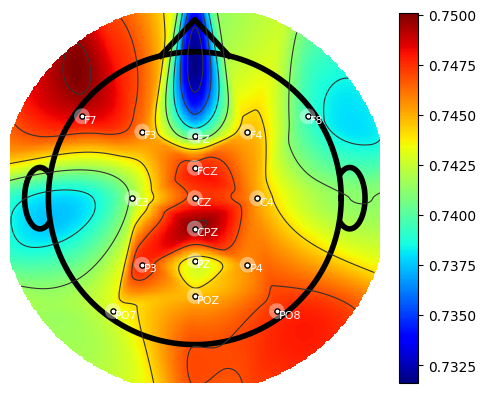

In [9]:
# Obtain the LZC values for each channel
lzc_results = nonlinear_parameters.lempelziv_complexity(signal=signal_long_epochs)

# Plot the LZC values averaged across epochs
fig,axes = plt.subplots()
norm = colors.Normalize(vmin=lzc_results.mean(axis=0).min(),
                        vmax=lzc_results.mean(axis=0).max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
plot_head(axes=axes,channel_set=ch_set,plot_channel_labels=True)
plot_topography(values=lzc_results.mean(axis=0),axes=axes,channel_set=ch_set,cmap='jet')
fig.colorbar(mapper,ax=axes,fraction=0.046,pad=0.04)

## Conclusion
So far the Medusa-Kernel Notebook on local analysis measurements! We have reviewed the main functions
of spectral analysis and non-linear analysis. We have also introduced the topographical representation
function, very useful when you want to represent a local activation measurement.

See you in the next tutorial!

## References
[1] https://ieee-dataport.org/documents/gib-uva-erp-bci-dataset
[2] Welch, P. D., _The use of Fast Fourier Transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms_, IEEE Transactions on Audio and Electroacoustics, vol 15, no 2, p 70–73, 1967, doi:10.1109/TAU.1967.1161901
[3] Klimesch, W., _EEG alpha and theta oscillations reflect cognitive and memory performance_, Brain Research Reviews, vol 29, no 2-3, p. 169–195, 1999. https://doi.org/10.1016/S0165-0173(98)00056-3
[4] Marcos-Martínez, D., Martínez-Cagigal, V., Santamaría-Vázquez, E., Pérez-Velasco, S., & Hornero, R., _Neurofeedback training based on motor imagery strategies increases EEG complexity in elderly population_, Entropy, vol 23, no 12, p. 1–19, 2021 https://doi.org/10.3390/e23121574
[5] Escudero, J., Abásolo, D., Hornero, R., Espino, P., & López, M., _Analysis of electroencephalograms in Alzheimer’s disease patients with multiscale entropy_, Physiological Measurement, vol 27, no 11, 2006, https://doi.org/10.1088/0967-3334/27/11/004
[6] Ibáñez-Molina, A. J., Iglesias-Parro, S., Soriano, M. F., & Aznarte, J. I., _Multiscale Lempel-Ziv complexity for EEG measures_, Clinical Neurophysiology, vol 126, no 3, p. 541–548, 2015, https://doi.org/10.1016/j.clinph.2014.07.012